**сиамская сеть, оцениваем схожесть текстов**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm.notebook import tqdm
# import gzip
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200  
tqdm.pandas()

def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
# каталог товаров
data = pd.read_excel('../data/text/okpd2.xlsx')
ppr(data)
data.sample(3)

записей: 19 464


,Код,Наименование,Комментарий
8749,10.83.13.120,Чай черный (ферментированный) в упаковках массой не более 3 кг,NaN
7684,08.93.10.110,Соль,NaN
1065,45.11,Услуги по торговле легковыми автомобилями и грузовыми автомобилями малой грузоподъемности,NaN


In [4]:
# нумеруем позиции каталога
data['id'] = range(len(data))
# будем использовать второй уровень каталога (две первые цифры)
data['group'] = data['Код'].str[:5]

In [5]:
# длина описаний в символах
data['Наименование'].str.len().describe([.95]).astype(int)

count    19464
mean        58
std         39
min          3
50%         50
95%        130
max        540
Name: Наименование, dtype: int64

In [6]:
# выкидываем короткие описания и дубликаты
data = data[ (data['group'].str.len()==5) & data['Наименование'].str.len().between(30,100) ]\
  .drop_duplicates(['Наименование'])[['id','group','Наименование']]\
  .reset_index(drop=True)

ppr(data)
data.sample(3)

записей: 9 632


,id,group,Наименование
4461,9117,13.10,Пряжа хлопчатобумажная суровая крученая для ткацкого производства прочая
8458,17262,66.19,Услуги платежных субагентов по приему платежей физических лиц
2749,5819,79.12,Услуги туроператоров по организации и составлению туров


In [7]:
# формируем списки описаний по группам
groups =  data[['id','group']].groupby('group')['id'].apply(list).reset_index()
ppr(groups)

записей: 596


In [8]:
# количество описаний в группах
groups['id'].str.len().describe([.95]).astype(int)

count    596
mean      16
std       24
min        1
50%        7
95%       62
max      185
Name: id, dtype: int64

In [9]:
# выкидываем группы с малым количеством описаний, обрезаем большие списки
n_samples = 10

ppr(groups)
groups = groups[ groups['id'].str.len()> n_samples ].reset_index(drop=True)
ppr(groups)
groups['id'] = groups['id'].apply(rng.permutation).str[:n_samples]

записей: 596
записей: 227


In [10]:
# похожие примеры
groups['id_eq'] = groups['id'].apply(rng.permutation)

In [11]:
groups

,group,id,id_eq
0,01.11,"[6143, 6145, 6083, 2827, 6119, 2847, 6069, 6060, 742, 1364]","[6069, 6083, 6119, 6060, 6145, 2827, 6143, 742, 2847, 1364]"
1,01.13,"[1373, 1375, 2863, 1376, 6225, 6207, 6227, 2874, 6228, 6237]","[2874, 1375, 1373, 6228, 2863, 1376, 6207, 6225, 6227, 6237]"
2,01.15,"[18165, 18168, 18178, 18169, 6245, 6248, 18164, 18166, 18171, 6246]","[6246, 6245, 18168, 18169, 6248, 18164, 18166, 18165, 18171, 18178]"
3,01.16,"[6258, 6253, 6270, 6249, 6259, 6264, 6272, 6271, 6269, 747]","[6269, 6270, 6253, 6264, 6259, 6258, 747, 6272, 6271, 6249]"
4,01.19,"[6297, 6289, 2891, 2893, 6276, 1384, 6288, 6283, 6287, 6273]","[1384, 6287, 6276, 6283, 6288, 6297, 6289, 2893, 6273, 2891]"
...,...,...,...
222,95.29,"[19278, 19300, 2815, 19285, 19272, 19318, 19266, 19287, 19262, 19321]","[19266, 19300, 19278, 19318, 19272, 19321, 19262, 19287, 19285, 2815]"
223,96.01,"[19341, 19351, 19343, 19372, 19376, 19398, 19371, 19324, 19381, 19357]","[19372, 19343, 19398, 19351, 19376, 19357, 19371, 19381, 19341, 19324]"
224,96.02,"[6025, 6027, 1353, 2817, 2818, 19415, 19410, 6026, 19414, 19412]","[6026, 2817, 19410, 1353, 2818, 19412, 6027, 19415, 6025, 19414]"
225,96.03,"[19435, 19439, 19441, 19434, 19432, 19425, 19430, 1354, 19440, 19424]","[19430, 19424, 19439, 19435, 19432, 1354, 19434, 19440, 19425, 19441]"


In [12]:
# непохожие примеры

# пары из разных групп
groups_ = groups[['group']].reset_index(drop=True)
groups_['group_neq'] = rng.permutation(groups['group'])
groups_ = groups_.query('group!=group_neq')

groups_ = groups_.merge( groups[['group','id']]\
                          .rename(columns={'group':'group_neq','id':'id_neq'}), 
                        on=['group_neq'])

groups_['id_neq'] = groups_['id_neq'].apply(rng.permutation)

# groups[['group','id']].rename(columns={'group':'group_neq','id':'id_neq'})

groups_

,group,group_neq,id_neq
0,01.11,42.22,"[109, 110, 18857, 111, 108, 18858, 2297, 18854, 4936, 4931]"
1,01.13,25.30,"[18598, 18584, 18592, 18580, 18585, 12951, 18591, 12933, 12961, 18594]"
2,01.15,17.23,"[10589, 10595, 10599, 10600, 10598, 10594, 10588, 10601, 10606, 10603]"
3,01.16,26.51,"[13437, 13473, 13431, 13495, 13508, 13499, 18660, 13440, 13543, 18658]"
4,01.19,02.10,"[6765, 6788, 6784, 2994, 6778, 6756, 6767, 6749, 6785, 6746]"
...,...,...,...
222,95.29,14.11,"[9604, 9597, 9610, 1616, 9605, 9607, 9606, 9611, 9599, 9598]"
223,96.01,30.30,"[15188, 4660, 15192, 4658, 15185, 4659, 15202, 999, 4668, 4663]"
224,96.02,25.71,"[13031, 13025, 1940, 943, 13033, 4102, 4101, 13022, 4103, 13032]"
225,96.03,59.20,"[5477, 2585, 17042, 17058, 17035, 17059, 17056, 17034, 17047, 2587]"


In [13]:
# группа, описания, похожие описания, непохожие описания
groups = groups.merge( groups_[['group','id_neq']], on=['group'] )
groups

,group,id,id_eq,id_neq
0,01.11,"[6143, 6145, 6083, 2827, 6119, 2847, 6069, 6060, 742, 1364]","[6069, 6083, 6119, 6060, 6145, 2827, 6143, 742, 2847, 1364]","[109, 110, 18857, 111, 108, 18858, 2297, 18854, 4936, 4931]"
1,01.13,"[1373, 1375, 2863, 1376, 6225, 6207, 6227, 2874, 6228, 6237]","[2874, 1375, 1373, 6228, 2863, 1376, 6207, 6225, 6227, 6237]","[18598, 18584, 18592, 18580, 18585, 12951, 18591, 12933, 12961, 18594]"
2,01.15,"[18165, 18168, 18178, 18169, 6245, 6248, 18164, 18166, 18171, 6246]","[6246, 6245, 18168, 18169, 6248, 18164, 18166, 18165, 18171, 18178]","[10589, 10595, 10599, 10600, 10598, 10594, 10588, 10601, 10606, 10603]"
3,01.16,"[6258, 6253, 6270, 6249, 6259, 6264, 6272, 6271, 6269, 747]","[6269, 6270, 6253, 6264, 6259, 6258, 747, 6272, 6271, 6249]","[13437, 13473, 13431, 13495, 13508, 13499, 18660, 13440, 13543, 18658]"
4,01.19,"[6297, 6289, 2891, 2893, 6276, 1384, 6288, 6283, 6287, 6273]","[1384, 6287, 6276, 6283, 6288, 6297, 6289, 2893, 6273, 2891]","[6765, 6788, 6784, 2994, 6778, 6756, 6767, 6749, 6785, 6746]"
...,...,...,...,...
222,95.29,"[19278, 19300, 2815, 19285, 19272, 19318, 19266, 19287, 19262, 19321]","[19266, 19300, 19278, 19318, 19272, 19321, 19262, 19287, 19285, 2815]","[9604, 9597, 9610, 1616, 9605, 9607, 9606, 9611, 9599, 9598]"
223,96.01,"[19341, 19351, 19343, 19372, 19376, 19398, 19371, 19324, 19381, 19357]","[19372, 19343, 19398, 19351, 19376, 19357, 19371, 19381, 19341, 19324]","[15188, 4660, 15192, 4658, 15185, 4659, 15202, 999, 4668, 4663]"
224,96.02,"[6025, 6027, 1353, 2817, 2818, 19415, 19410, 6026, 19414, 19412]","[6026, 2817, 19410, 1353, 2818, 19412, 6027, 19415, 6025, 19414]","[13031, 13025, 1940, 943, 13033, 4102, 4101, 13022, 4103, 13032]"
225,96.03,"[19435, 19439, 19441, 19434, 19432, 19425, 19430, 1354, 19440, 19424]","[19430, 19424, 19439, 19435, 19432, 1354, 19434, 19440, 19425, 19441]","[5477, 2585, 17042, 17058, 17035, 17059, 17056, 17034, 17047, 2587]"


In [14]:
# разворачиваем в список пар
groups = pd.DataFrame({'id':groups['id'].explode(), 
              'id_eq':groups['id_eq'].explode(),
              'id_neq':groups['id_neq'].explode()})
ppr(groups)
groups.sample(3)

записей: 2 270


,id,id_eq,id_neq
208,5746,5751,14897
95,12342,12338,17700
186,16748,16751,18616


In [15]:
# формируем датасет
pair = groups[['id','id_eq']].rename(columns={'id':'id_L','id_eq':'id_R'})
pair['target'] = 1
pair = pd.concat([ pair, groups[['id','id_neq']]\
           .rename(columns={'id':'id_L','id_neq':'id_R'}) ])\
           .fillna(0).astype(int)

pair.sample(3)

,id_L,id_R,target
137,2074,2075,1
9,6746,5094,0
41,18384,12503,0


In [16]:
%xdel groups
%xdel groups_

## очистка данных

In [17]:
# data['ttext_clean'] = data['ttext']\
#     .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
#     .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
#     .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

In [18]:
# data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [19]:
data['ttext_clean'] = data['Наименование'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

In [20]:
data.sample(3)

,id,group,Наименование,ttext_clean
145,231,11.02,Сусло виноградное консервированное,"[сусло, виноградное, консервированное]"
5195,10156,15.11,"Шкурки хоря пушно-меховые выделанные целые и их части или обрезки, собранные","[шкурки, хоря, пушно, меховые, выделанные, целые, и, их, части, или, обрезки, собранные]"
8018,16080,38.32,Лом и отходы тантала и его сплавов,"[лом, и, отходы, тантала, и, его, сплавов]"


In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 9 632
записей: 9 632


In [22]:
data.sample(3)

,id,group,Наименование,ttext_clean
5376,10523,17.12,Картон для фильтрующих элементов масляных и воздушных фильтров,"[картон, для, фильтрующих, элементов, масляных, и, воздушных, фильтров]"
5072,9986,14.20,"Рукавицы женские из хлопчатобумажных тканей, подкладка меховая","[рукавицы, женские, из, хлопчатобумажных, тканей, подкладка, меховая]"
4993,9885,14.20,"Жакеты женские с верхом из хлопчатобумажных тканей, подкладка меховая","[жакеты, женские, с, верхом, из, хлопчатобумажных, тканей, подкладка, меховая]"


In [23]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 9 976


## кодируем слова

In [24]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

  0%|          | 0/9632 [00:00<?, ?it/s]

In [25]:
data[['ttext_clean','code']].sample(3)

,ttext_clean,code
730,"[пряжа, хлопчатобумажная, нитки, швейные, хлопчатобумажные]","[6725, 9278, 4808, 9582, 9281]"
943,"[радиоприемники, широковещательные]","[6859, 9619]"
3393,"[услуги, по, рыбохозяйственной, мелиорации, морских, и, минерализированных, водных, объектов]","[8968, 5911, 7298, 4048, 4324, 2416, 4191, 968, 5004]"


In [26]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    9632
mean        7
std         2
min         2
25%         5
50%         7
75%         9
max        16
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

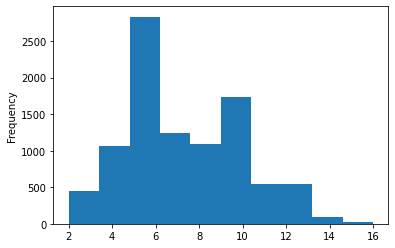

In [27]:
data['code'].str.len().plot.hist()

In [28]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

16

In [29]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

  0%|          | 0/9632 [00:00<?, ?it/s]

In [30]:
data['code'].str.len().describe().astype(int)

count    9632
mean       16
std         0
min        16
25%        16
50%        16
75%        16
max        16
Name: code, dtype: int64

In [31]:
# data

## строим датасет

In [32]:
pair

,id_L,id_R,target
0,6143,6069,1
0,6145,6083,1
0,6083,6119,1
0,2827,6060,1
0,6119,6145,1
...,...,...,...
226,6036,16062,0
226,19462,16027,0
226,19450,16032,0
226,19452,16041,0


In [33]:
dataset = pair\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )
ppr(dataset)
dataset.sample(3)

записей: 4 540


,id_L,id_R,target,code_L,code_R
2054,9800,3842,0,"[8815, 1445, 2081, 6707, 2436, 9074, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7083, 9439, 363, 2416, 206, 2029, 5832, 935, 7456, 4, 3580, 0, 0, 0, 0, 0]"
636,7317,7320,1,"[8835, 3054, 3920, 2038, 2141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8835, 3054, 3920, 3006, 3051, 5353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2654,11693,11705,1,"[7806, 9246, 3628, 2646, 700, 9808, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[158, 7743, 4595, 917, 700, 1986, 1600, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [34]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((4540, 16), (4540, 16), (4540, 1))

In [35]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [36]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((4540, 16), (4540, 16), (4540, 1), 9974)

In [37]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [38]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

16

## модель

In [39]:
embed_len = 128
embed_input_dim, embed_len, seq_len

(9974, 128, 16)

In [40]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.8.0', '2.8.0')

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss
from tensorflow import cast

$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [42]:
def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

In [43]:
embed_input_dim,seq_len,embed_len

(9974, 16, 128)

In [44]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

2022-05-18 16:24:00.143073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 16:24:00.170624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 16:24:00.170781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 16:24:00.171312: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [45]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

# классификатор
predictions = Dense(1, activation='relu')(merged)

# создаём модель
model = Model([input_l,input_r], predictions )

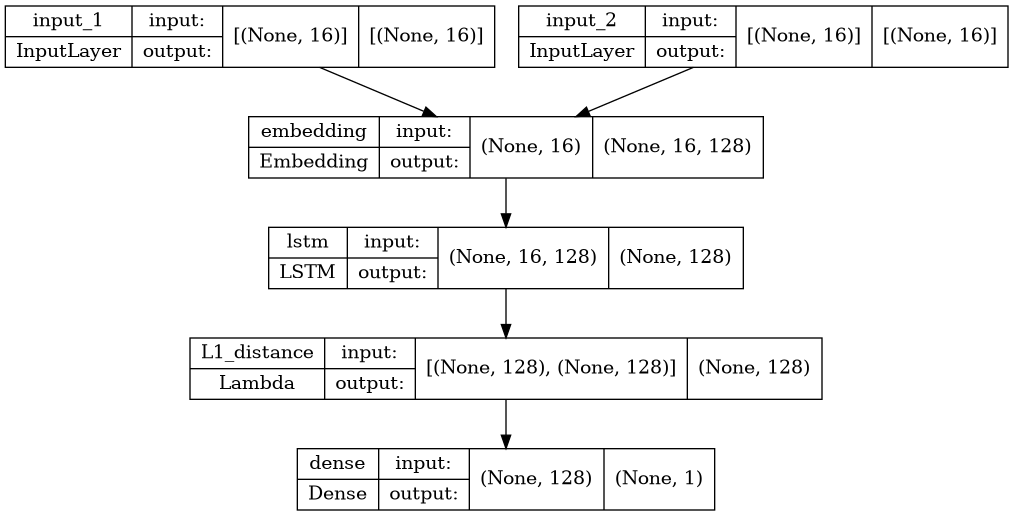

In [46]:
plot_model(model, show_layer_names=True, show_shapes=True )

In [47]:
learning_rate = 9e-3
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [48]:
x_left.shape,target.shape

((4540, 16), (4540, 1))

In [49]:
%%time

n_epochs = 15

history = model.fit( [x_left, x_right], target,epochs = n_epochs, batch_size = 1024, )

Epoch 1/15
5/5 [==============================] - 2s 38ms/step - loss: 0.3945 - acc: 0.4923
Epoch 2/15
5/5 [==============================] - 0s 37ms/step - loss: 0.2183 - acc: 0.3537
Epoch 3/15
5/5 [==============================] - 0s 36ms/step - loss: 0.1411 - acc: 0.1648
Epoch 4/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0987 - acc: 0.1009
Epoch 5/15
5/5 [==============================] - 0s 35ms/step - loss: 0.0797 - acc: 0.0720
Epoch 6/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0625 - acc: 0.0465
Epoch 7/15
5/5 [==============================] - 0s 38ms/step - loss: 0.0471 - acc: 0.0253
Epoch 8/15
5/5 [==============================] - 0s 38ms/step - loss: 0.0333 - acc: 0.0159
Epoch 9/15
5/5 [==============================] - 0s 37ms/step - loss: 0.0196 - acc: 0.0108
Epoch 10/15
5/5 [==============================] - 0s 35ms/step - loss: 0.0095 - acc: 0.0059
Epoch 11/15
5/5 [==============================] - 0s 37ms/step - loss: 0.0042 

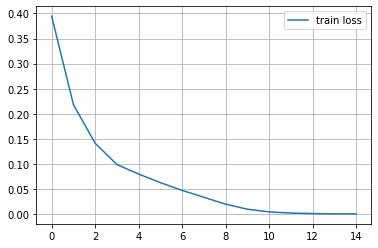

In [50]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

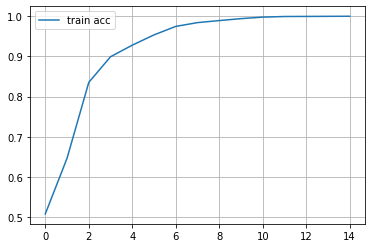

In [51]:
plt.plot( 1. - np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [52]:
# gc.collect()

## тест

In [53]:
dataset['dist'] = model.predict([x_left,x_right,])

In [54]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_R','Наименование':'ttext_R'}),on='id_R')\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_L','Наименование':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]

# data_dist.sample(3)

In [55]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,4540.0,1.120048,1.243246,0.0,0.0,0.50191,2.121595,5.744201


In [56]:
# похожие тексты
data_dist[ (data_dist['dist']<0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(10)

,ttext_L,ttext_R,dist
2672,Блоки дверные пластмассовые и пороги для них,Изделия санитарно-технические аналогичные пластмассовые,0.0
1375,"Ткани из металлической нити и ткани из металлизированной пряжи, не включенные в другие группировки","Ткани, пропитанные другими полимерными композициями, или с покрытием, прочие",0.0
3904,Светодиоды инфракрасного диапазона,Приборы полупроводниковые прочие,0.0
2034,"Орех мускатный, мацис и кардамон обработанные","Услуги по производству приправ и пряностей отдельные, выполняемые субподрядчиком",0.0
637,Услуги по розничной торговле прочими пищевыми продуктами в специализированных магазинах,Услуги по розничной торговле пищевыми маслами и жирами в специализированных магазинах,0.0
3109,"Емкости из прочих металлов для сжатых или сжиженных газов прочие, не включенные в другие группировки","Резервуары и газгольдеры, возводимые комбинированным способом",0.0
4508,"Услуги по сбору неопасных отходов городского хозяйства, пригодных для повторного использования","Суда и средства плавучие прочие, предназначенные на слом",0.0
274,Сеянцы деревьев твердолиственных пород,Сеянцы кустарников с открытой корневой системой,0.0
237,Устройства контрольно-измерительные,"Краны, вентили, клапаны для раковин, моек, биде, унитазов, ванн и аналогичная арматура",0.0
2500,"Оборудование специального назначения прочее, не включенное в другие группировки",Машины наборные шрифтолитейные,0.0


In [57]:
# НЕпохожие тексты
data_dist[ (data_dist['dist']>0.5) ].sample(10)

,ttext_L,ttext_R,dist
4503,"Услуги по сбору прочих неопасных отходов, непригодных для повторного использования",Услуги по подготовке схемы планировочной организации земельного участка,1.849284
1905,"Карамель с марципановыми, ореховыми и шоколадными начинками",Услуги по ремонту и замене подошв,4.398679
3029,"Дефектоскопы, вагоны дефектоскопные, тележки","Устройства сцепные (тягово-сцепные, седельно-сцепные и буксирные)",1.913654
2799,Подшипники качения шариковые закрытого типа,Инструменты ручные прочие с механизированным приводом,1.764742
3084,"Анатоксины, применяемые в ветеринарии",Красители основные и составы на их основе,1.590832
3730,"Средства измерений массы, силы, энергии, линейных и угловых величин, температуры",Баллоны стальные бесшовные большого объема,1.637767
3053,"Оксиды, пероксиды и гидроксиды прочих металлов","Станки гайконарезные и резьбонарезные металлорежущие, не включенные в другие группировки",2.288135
1665,Мороженое молочное без наполнителей и добавок,"Полосы и ленты из меди толщиной более 0,15 мм",1.580871
2527,"Халаты, фартуки, жилеты и сорочки мужские производственные и профессиональные",Услуги государственного управления в бюджетно-финансовой и налоговой сфере,1.781216
749,Толстолобик свежий или охлажденный,Породы горные магматические и метаморфические,2.009488
